In [1]:
import math
import os
import random
import re

from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.callbacks import LearningRateScheduler
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(1234)

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
path_data = r'/content/drive/MyDrive/Colab Notebooks/'

# Contains txt files
label_dir = path_data + 'garbage_txt/'
# Contains img files
image_dir = path_data + 'garbage_img/'

Mounted at /content/drive


# Read labels

In [3]:
# Read train, validation, test split from txt files
train_file = label_dir + 'one-indexed-files-notrash_train.txt'
val_file   = label_dir + 'one-indexed-files-notrash_val.txt'
test_file  = label_dir + 'one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['path', 'label'])

# Converts label id to name
def label_id_to_name(id):
  label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
  return label_map[id]

df_train['label'] = df_train['label'].apply(label_id_to_name)
df_valid['label'] = df_valid['label'].apply(label_id_to_name)
df_test['label'] = df_test['label'].apply(label_id_to_name)

# Change file name to file path i.e. cardboard114.jpg	 to cardboard/cardboard114.jpg	
df_train.path = df_train.path.str.extract(r'([a-z]+)')[0] + "/" + df_train.path
df_valid.path = df_valid.path.str.extract(r'([a-z]+)')[0] + "/" + df_valid.path
df_test.path = df_test.path.str.extract(r'([a-z]+)')[0] + "/" + df_test.path

# Read images

In [4]:
# Set data directory and parameters
batch_size = 32
image_size = (224, 224)

from tensorflow.keras.applications.resnet50 import preprocess_input

# Create an instance of ImageDataGenerator with preprocessing function
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input)

# Load train, validation, and test data from all dataframes
train_data = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

val_data = validation_datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


#Calculate class weights

In [5]:
train_stats = df_train.groupby("label").count().reset_index()
train_stats.columns = ["label", "count"]

total_samples = train_stats['count'].sum()
num_classes = len(train_stats)

# Compute class weights
class_weight = {}
for i in range(num_classes):
    class_weight[i] = total_samples / (num_classes * train_stats.iloc[i]['count'])

print(class_weight)

{0: 1.0267131242740999, 1: 0.832391713747646, 2: 1.0303030303030303, 3: 0.7311827956989247, 4: 0.8491834774255523, 5: 3.238095238095238}


# Construct model

In [6]:
input_shape = (224, 224, 3)

# Define the number of classes
num_classes = 6

base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer to reduce the number of parameters
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully connected layer for classification
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

def step_decay(epoch):
    initial_lr = 1e-3 # initial learning rate
    drop = 0.5 # factor by which the learning rate will be reduced
    epochs_drop = 3 # number of epochs after which the learning rate will be reduced
    lr = initial_lr * drop**(epoch // epochs_drop) # calculate the new learning rate
    return lr

from keras.callbacks import ReduceLROnPlateau

# define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Set up the learning rate scheduler
#lr_scheduler = LearningRateScheduler(step_decay)

# Train the model
history = model.fit(
    train_data,
    epochs=30,
    steps_per_epoch=train_data.samples//batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples//batch_size,
    callbacks=[lr_scheduler, early_stop],
    class_weight=class_weight)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/30
55/55 [==============================] - 392s 7s/step - loss: 0.9374 - accuracy: 0.6722 - val_loss: 0.4668 - val_accuracy: 0.8219 - lr: 1.0000e-04
Epoch 2/30
55/55 [==============================] - 48s 861ms/step - loss: 0.4421 - accuracy: 0.8479 - val_loss: 0.3826 - val_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 3/30
55/55 [==============================] - 47s 852ms/step - loss: 0.3552 - accuracy: 0.8836 - val_loss: 0.3366 - val_accuracy: 0.8781 - lr: 1.0000e-04
Epoch 4/30
55/55 [==============================] - 47s 847ms/step - loss: 0.2686 - accuracy: 0.9107 - val_loss: 0.3218 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 5/30
55/55 [==============================] - 49s 887ms/step - loss: 0.2276 - accuracy: 0.9194 - val_loss: 0.3514 - val_accuracy: 0.8813 - lr: 1.0000e-04
Epoch 6/30
55/55 [==============================] - 51s 923ms/step - loss: 0.2073 - accuracy: 0.9309 - val_loss: 0.2533 - val_accuracy: 0

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

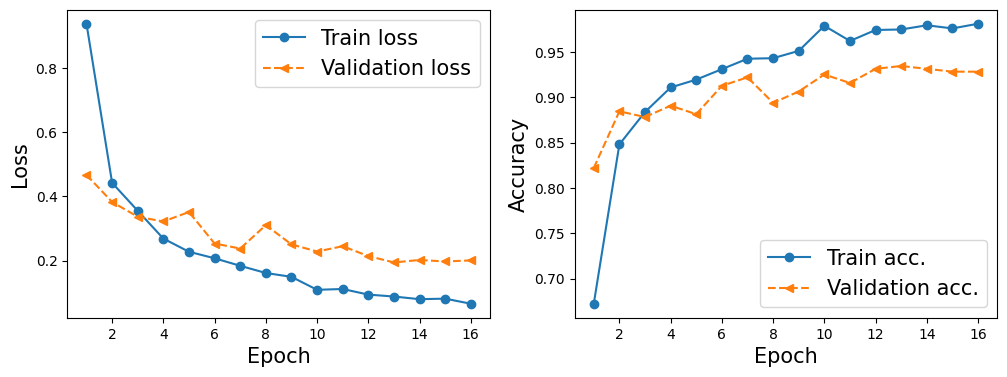

In [8]:
# Plot loss and accuracy data
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# Evaluate model performance

In [9]:
# Evaluate model performance on test dataset
test_data = validation_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_dir,
    x_col="path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=1234
)

test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Found 431 validated image filenames belonging to 6 classes.
14/14 [==============================] - 76s 6s/step - loss: 0.2494 - accuracy: 0.9188
Test loss: 0.24943524599075317
Test accuracy: 0.9187934994697571


14/14 [==============================] - 10s 633ms/step


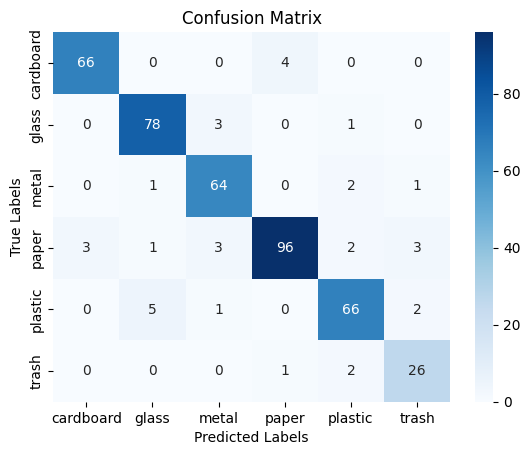

In [10]:
# Print confusion matrix

y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true_labels, y_pred_labels)
# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Obtain precision and recall for each class
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.96      0.94      0.95        70
       glass       0.92      0.95      0.93        82
       metal       0.90      0.94      0.92        68
       paper       0.95      0.89      0.92       108
     plastic       0.90      0.89      0.90        74
       trash       0.81      0.90      0.85        29

    accuracy                           0.92       431
   macro avg       0.91      0.92      0.91       431
weighted avg       0.92      0.92      0.92       431



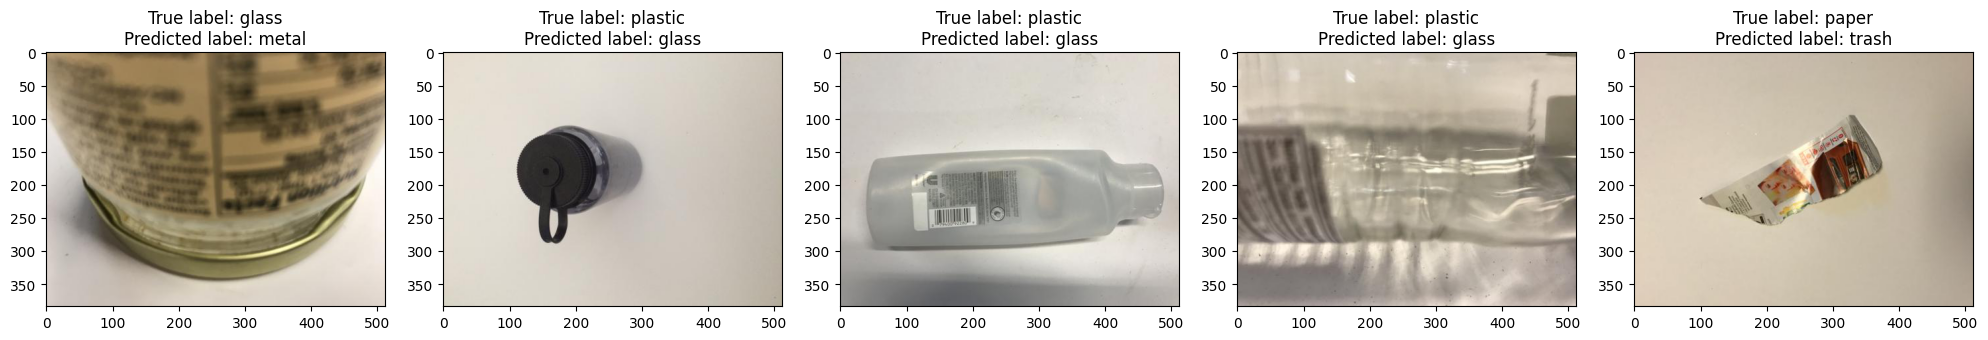

In [12]:
# Print few wrongly classified images

wrong_indices = np.where(y_true_labels != y_pred_labels)[0]
num_samples = 5
samples = np.random.choice(wrong_indices, size=num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))

for i, sample in enumerate(samples):
    img_path = test_data.filepaths[sample]
    img = plt.imread(img_path)
    true_label = class_names[y_true_labels[sample]]
    predicted_label = class_names[y_pred_labels[sample]]
    axes[i].imshow(img)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    
plt.tight_layout()
plt.show()